In [1]:
from pippi.oscs import Osc, Osc2d, Pulsar, Pulsar2d, Alias, Bar
from pippi import dsp, interpolation, wavetables, fx, oscs,soundpipe
from pippi.soundbuffer import SoundBuffer
from pippi.wavesets import Waveset
from pippi import dsp, fx
import random
import sounddevice as sd
from IPython.display import Audio
import librosa as lib
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pippi import dsp, noise
import scipy
from helpers import *
import param_generation as pg
sr=48000
sd.default.samplerate = sr
plt.figure(figsize=(8, 5))



<Figure size 800x500 with 0 Axes>

1.0000000000017342


1

<Figure size 576x360 with 0 Axes>

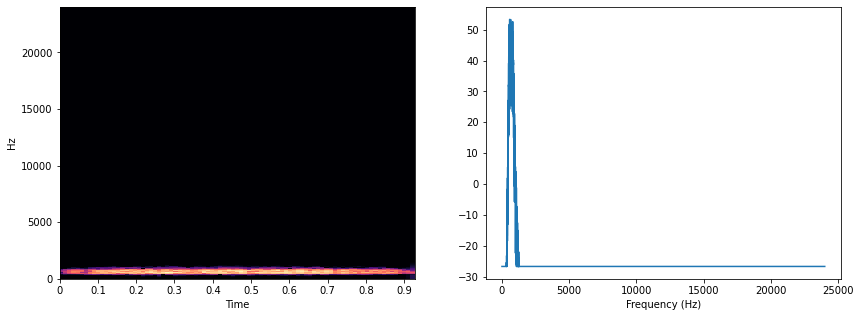

In [2]:
p=pg.RandomParams()
pg.min_length = 1.0
print(p.getLength())

s=pg.Synth(p)
specShow(s.buff)
sd.play(s.buff)

p.length

48000
1.0000169350878085
CPU times: user 1.67 s, sys: 66.4 ms, total: 1.73 s
Wall time: 1.73 s


<Figure size 576x360 with 0 Axes>

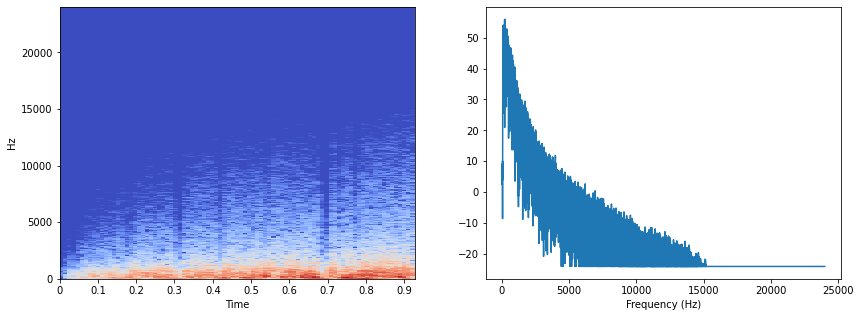

In [3]:
%%time
print(sr)
out = dsp.buffer(length=5)
p=pg.RandomParams()
pg.min_length = 1.0
print(p.getLength())

s=pg.Synth(p)
specShow(s.buff)
out.dub(s.buff,1.0)
sd.play(out)


In [4]:
%%time
from tqdm.notebook import tqdm
import multiprocessing

def prog_map(elms, f, desc="Synth", chunksize=1,procs=8,order=True):
    with tqdm(elms, desc=desc) as t:
        with multiprocessing.Pool(procs, initializer=tqdm.set_lock,
              initargs=(tqdm.get_lock(),)) as p:
            if (order):
                pool = list(p.imap(f, t, chunksize=chunksize))
            else:
                pool = list(p.imap_unordered(f, t, chunksize=chunksize))
            return pool

NPOOL=1000
pg.min_length = 1.0
def rand_synth(i):
    p=pg.RandomParams()
    s=pg.Synth(p)
    return s
pool = prog_map(range(NPOOL), rand_synth, order=False)



CPU times: user 313 ms, sys: 325 ms, total: 637 ms
Wall time: 3.23 s


In [5]:
pool[0:10]

In [6]:
import librosa

def mfcc(audio, nwin=256, nfft=512, fs=16000, nceps=13):
    #return librosa.feature.mfcc(y=audio, sr=44100, hop_length=nwin, n_mfcc=nceps)
    return [np.transpose(librosa.feature.mfcc(y=audio, sr=fs, n_fft=nfft, win_length=nwin,n_mfcc=nceps))]

def add_feature(mfcc1, rmsa1):
    tmfcc1 = np.zeros((mfcc1.shape[0],mfcc1.shape[1]+rmsa1.shape[0]))
    n = mfcc1.shape[0]
    m = mfcc1.shape[1]
    w = rmsa1.shape[0]
    tmfcc1[0:n,0:m] = mfcc1[0:n,0:m]
    tmfcc1[0:n,m:m+w]   = np.transpose(rmsa1[0:w,0:n])
    return tmfcc1

def std_mfcc(mfcc):
    return (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)

def calc_features(a1):
    fs = sr
    mfcc1 = mfcc(a1, nwin=256, nfft=512, fs=fs, nceps=26)[0]
    mfcc1 = std_mfcc(mfcc1)
    rmsa1 = librosa.feature.rms(a1)
    cent1 = librosa.feature.spectral_centroid(y=a1, sr=fs)
    rolloff1 = librosa.feature.spectral_rolloff(y=a1, sr=fs, roll_percent=0.1)
    chroma_cq1 = librosa.feature.chroma_cqt(y=a1, sr=fs, n_chroma=10)
    onset_env1 = librosa.onset.onset_strength(y=a1, sr=sr)
    try:
        pulse1 = librosa.beat.plp(onset_envelope=onset_env1, sr=sr)
    except:
        pulse1 = np.ones((mfcc1.shape[0],))
    mfcc1 = add_feature(mfcc1, rmsa1)
    mfcc1 = add_feature(mfcc1, rolloff1/fs)
    mfcc1 = add_feature(mfcc1, cent1/fs)
    mfcc1 = add_feature(mfcc1, chroma_cq1)
    mfcc1 = add_feature(mfcc1, onset_env1.reshape(1,onset_env1.shape[0]))
    mfcc1 = add_feature(mfcc1, pulse1.reshape(1,onset_env1.shape[0]))
    return mfcc1

def cross_correlation(mfcc1, mfcc2, nframes):
    n1, mdim1 = mfcc1.shape
    n2, mdim2 = mfcc2.shape
    #print((nframes,(n1,mdim1),(n2,mdim2)))
    if (n2 <= nframes):
        t = np.zeros((nframes,mdim2))
        t[0:n2,0:mdim2] = mfcc2[0:n2,0:mdim2]
        mfcc2 = t
    if (n1 < nframes):
        t = np.zeros((nframes,mdim1))
        t[0:n1,0:mdim1] = mfcc2[0:n1,0:mdim1]
        mfcc1 = t
        n1 = nframes
    n = n1 - nframes + 1
    #c = np.zeros(min(n2,n))
    c = np.zeros(n)
    #for k in range(min(n2,n)):
    for k in range(n):
        cc = np.sum(np.multiply(mfcc1[k:k+nframes], mfcc2[:nframes]), axis=0)
        c[k] = np.linalg.norm(cc,1)
    return c



def rosa_compare(a1, a2, fs=48000, trim=60*15, correl_nframes=50, plotit=True):
    sr = fs
    #print("Ref samples: %s Find samples: %s" % (a1.shape[0],a2.shape[0]))
    mfcc1 = calc_features(a1)
    mfcc2 = calc_features(a2)
    #mfcc1 = mfcc(a1, nwin=256, nfft=512, fs=fs, nceps=26)[0]
    #mfcc2 = mfcc(a2, nwin=256, nfft=512, fs=fs, nceps=26)[0]
    c = cross_correlation(mfcc1, mfcc2, nframes=correl_nframes)
    max_k_index = np.argmax(c)
    # offset = max_k_index * (a1.shape[0]/rmsa1.shape[1]) / float(fs) # * over / sample rate
    #print("Best matching window: %s" % max_k_index)
    #print("mean %s std %s" % (np.mean(c) , np.std(c)))
    score = (c[max_k_index] - np.mean(c)) / (0.0000001 + np.std(c)) # standard score of peak
    return score



In [7]:
%%time 
def pool_features(s):
    return calc_features(np.asarray(s.buff.frames[0:,0]))

features = prog_map(pool, pool_features)
#for i in range(len(pool)):
#    s = pool[i]
#    features.append(calc_features(np.asarray(s.buff.frames[0:,0])))

/home/hindle1/.local/lib/python3.6/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/hindle1/.local/lib/python3.6/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/hindle1/.local/lib/python3.6/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/hindle1/.local/lib/python3.6/site-packages/librosa/filters.py:221: Use


CPU times: user 1.63 s, sys: 495 ms, total: 2.12 s
Wall time: 59.1 s


In [8]:
print(features[1].shape, features[1].shape[0] * features[1].shape[1])

(87, 41) 3567


In [88]:
%%time
import helpers
input_snd = dsp.read('tritrack.wav')
input_snd.frames = helpers.butter_bandpass_filter(input_snd.frames,1024,10000,sr)
ttfeatures = calc_features(np.asarray(input_snd.frames[0:,0]))

CPU times: user 2.64 s, sys: 1.09 s, total: 3.73 s
Wall time: 2.16 s


In [89]:
print(ttfeatures.shape)

(5626, 41)


In [90]:
def acor(mfcc1,mfcc2):
    cc = np.sum(np.multiply(mfcc1, mfcc2), axis=0)
    return np.linalg.norm(cc,1)
def sim(mfcc1,mfcc2):
    n = mfcc1.shape[0]
    return np.sqrt(np.sum((mfcc1 - mfcc2)**2)/n)


In [91]:
%%time
def linear():
    # import itertools
    ttmax = ttfeatures.shape[0]
    ttres = np.zeros((ttmax,len(features)))
    n = features[0].shape[0]
    # args = itertools.product(range(ttmax - n),range(len(features)))
    print((ttmax-n)*len(features))
    #def sim_tuples(t,n=n):
    #    (i,j) = t
    #    return (i,j,sim(features[j], ttfeatures[i:i+n]))
    #tuples = prog_map(args, sim_tuples )
    #for t in tuples:
    #    (i,j,v) = t
    #    ttres[i,j] = v
    for i in range(ttmax - n):
        for j in range(len(features)):
            ttres[i,j] = sim(features[j], ttfeatures[i:i+n])


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


In [92]:

%%time
import itertools
ttmax = ttfeatures.shape[0]
ttres = np.zeros((ttmax,len(features)))
n = features[0].shape[0]
args = itertools.product(range(ttmax - n),range(len(features)))

def sim_tuples(t,n=n):
    (i,j) = t
    return (i,j,sim(features[j], ttfeatures[i:i+n]))
# not - 2m37s
# 1 - 5 minutes
# 512 - 44.4
# 1024 - 43.4
# 2048 - 43.7 43.4 43.9 43.9 44
# 2048 @ 4 - 55.7
# 2048 @ 12 - 43.9
# 2048 @ 7  - 44.6
# 8*2048 - 43.3
# 4*8*2048 - 45
# 16*8*2048 - 47.3
for t in prog_map(args, sim_tuples, chunksize=2048, order=False):
    (i,j,v) = t
    ttres[i,j] = v



CPU times: user 11.8 s, sys: 1.19 s, total: 13 s
Wall time: 44.7 s


In [93]:
print(n,ttmax,len(features))

87 5626 1000


In [94]:
ttfilt = np.nan_to_num(ttres,nan=np.Inf)
ttargmin =np.argmin(ttfilt,axis=1)
print(ttargmin[0:1000])
#print(np.argmin(ttres[0:1000],axis=1))


    

[681 681 681 459 459 459 459 459 459 459 459 459 459 459 459 459 459 459
  63  63  63 459 459 459  63  63  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15 971  15 588  15  15  15  15  15  15  15
  15 588 427 427 588 774 588 588  99 588 588 588 588 588 138 619 588 774
 182 588 619 486 346 346 580 619 619 346 321 130 305 346 588 282 720 233
 893 945 945 945 681 681 442 945  20 720 720 720 808 644  11  11 459  11
 720 459 459 720 459 720 459 459 459 459 459 459 459 459 459 459 459 459
 459  38 720 346 528 346 346 346 588 633 346 346 720 901  20 644 774 321
 650 588 588 233 815 911 442 298 130 130 130 130 911 633 815 700  99 804
 633 619 495 681 633 495 495 495 804 495 495 495 495 495 495 495 143 143
 143 459 143 143 143 459 459 459 346 346   3 342 459 442 502 644 321 130
 138 486 459 901 168 486 117 321  38 442 644  20 434 434 442 459 486 700
  38 459 459 720 644 588 644  20 644 434 434 644 804 346 227 546 442 804
  63 644 434 434 588  38 644 459 227 644  38 644 64

In [98]:
out = dsp.buffer(length=512*ttfeatures.shape[0]/sr)
skip = sr//(12*512)
steps = ttargmin.shape[0] // skip
for i in range(steps):
    j = i * skip
    index = int(ttargmin[j])
    s = pool[index]
    t = j * 512 / sr
    print(t,index)
    out.dub(s.buff,t)

0.0 681
0.07466666666666667 459
0.14933333333333335 459
0.224 459
0.2986666666666667 15
0.37333333333333335 15
0.448 15
0.5226666666666666 15
0.5973333333333334 427
0.672 588
0.7466666666666667 588
0.8213333333333334 346
0.896 305
0.9706666666666667 945
1.0453333333333332 20
1.12 11
1.1946666666666668 459
1.2693333333333334 459
1.344 459
1.4186666666666667 346
1.4933333333333334 20
1.568 233
1.6426666666666667 130
1.7173333333333334 804
1.792 495
1.8666666666666667 495
1.9413333333333334 143
2.016 346
2.0906666666666665 321
2.1653333333333333 486
2.24 434
2.3146666666666667 459
2.3893333333333335 644
2.464 546
2.538666666666667 588
2.6133333333333333 644
2.688 20
2.7626666666666666 774
2.8373333333333335 901
2.912 486
2.986666666666667 774
3.0613333333333332 305
3.136 15
3.2106666666666666 815
3.2853333333333334 99
3.36 588
3.4346666666666668 15
3.509333333333333 815
3.584 633
3.6586666666666665 687
3.7333333333333334 675
3.808 675
3.8826666666666667 675
3.957333333333333 675
4.032 675

In [99]:
sd.play(out)

In [97]:
out.write("rendered-1024-10000.wav")

In [ ]:
input_snd = dsp.read('tritrack.wav')
tritracksim = np.zeros((tritrackseconds,len(pool)))
ttfeatures = []
input_snd_max = input_snd.shape[0]
inc = sr
steps = input_snd_max // inc
for i in range(steps):
    ttfeatures.append(calc_features(np.asarray(s.buff.frames[0:,0])))

In [109]:
input_snd = dsp.read('tritrack.wav')
tritrackseconds = 10
tritracksim = np.zeros((tritrackseconds,len(pool)))
for second in range(tritrackseconds):
    start = sr * second
    y = np.asarray(input_snd.frames[start:(start+3*sr),0])
    for i in range(len(pool)):
        x = np.asarray(pool[i].buff.frames[0:,0])        
        v = rosa_compare(x,y)
        tritracksim[second,i] = v
        print("second: %s i: %s v: %s" % (second,i, v))
tritracksim

second: 0 i: 0 v: 4.611870960981704
second: 0 i: 1 v: 4.532994083454586
second: 0 i: 2 v: 3.4376690155407976
second: 0 i: 3 v: 2.350529723318219
second: 0 i: 4 v: 1.920265028477945
second: 0 i: 5 v: 2.6555613651303074
second: 0 i: 6 v: 1.2460445442353139
second: 1 i: 0 v: 3.7209604768851436
second: 1 i: 1 v: 2.1744182378818615
second: 1 i: 2 v: 3.0110771491529307
second: 1 i: 3 v: 2.5430714871804994
second: 1 i: 4 v: 2.1941648423876554
second: 1 i: 5 v: 2.0413518493343554
second: 1 i: 6 v: 1.6039994005788747
second: 2 i: 0 v: 2.822666603106947
second: 2 i: 1 v: 3.578212273017333
second: 2 i: 2 v: 4.370820578153549
second: 2 i: 3 v: 2.2918496745987946
second: 2 i: 4 v: 1.7827246673050068
second: 2 i: 5 v: 2.4666700825545442
second: 2 i: 6 v: 1.6559402615678291
second: 3 i: 0 v: 3.9763829787226848
second: 3 i: 1 v: 3.063487961593354
second: 3 i: 2 v: 4.163110509938635
second: 3 i: 3 v: 2.500067361952316
second: 3 i: 4 v: 2.5338557708173686
second: 3 i: 5 v: 1.9150066709925244
second: 3 i

array([[4.61187096, 4.53299408, 3.43766902, 2.35052972, 1.92026503,
        2.65556137, 1.24604454],
       [3.72096048, 2.17441824, 3.01107715, 2.54307149, 2.19416484,
        2.04135185, 1.6039994 ],
       [2.8226666 , 3.57821227, 4.37082058, 2.29184967, 1.78272467,
        2.46667008, 1.65594026],
       [3.97638298, 3.06348796, 4.16311051, 2.50006736, 2.53385577,
        1.91500667, 1.65989239],
       [4.70563192, 2.59869332, 3.38528496, 2.90913293, 3.13159774,
        2.27751369, 1.77541168],
       [3.92488032, 2.31927938, 3.11012285, 2.31080209, 1.46985754,
        2.28260663, 2.06823625],
       [3.73103384, 2.68311814, 3.19792979, 2.38227678, 1.55522784,
        2.31756499, 2.28595175],
       [2.85457189, 3.64451115, 3.58270046, 2.20774225, 1.69562442,
        3.03189575, 1.38772214],
       [4.170429  , 2.49157805, 3.38262753, 2.75832748, 1.99665773,
        1.78853783, 1.7257119 ],
       [4.74308954, 3.92758117, 3.4435586 , 1.9410432 , 1.89791406,
        1.8706524 , 1.5

In [116]:
for i in np.argmax(tritracksim,axis=1):
    sd.play(pool[i].buff)


In [64]:
%%time

out = dsp.buffer(length=1)
for i in range(1): 
    p=pg.RandomParams()
    s=pg.Synth(p)
    out.dub(s.buff,p.start)

sd.play(out)
specShow(out)

KeyboardInterrupt: 

<Figure size 576x360 with 0 Axes>

In [100]:
input_snd = dsp.read('tritrack.wav')


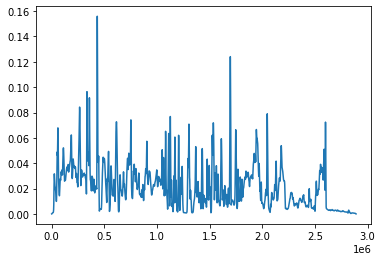

In [103]:
wss = 0.2 # seconds
ws = int(wss * sr)
window = np.hanning(ws)/ws
env = np.tanh(np.convolve(np.abs(input_snd.frames[0:,0]), window))
plt.plot(env)
plt.show()